# Phishing Detection (Using small dataset of only ~1200 observations)

Dataset & Info: http://archive.ics.uci.edu/ml/datasets/Website+Phishing
<br>
<br>
Each row represents a website. The features represents characteristics of websites that are useful for detecting phishing, where 1 indicates legitimacy, 0 indicates suspicion, and -1 indicates phishing

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot
plt.rcParams["figure.figsize"] = (10,6)

from sklearn.cross_validation import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

C:\Anaconda\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Raw Data (1 = legitimate, 0 = suspicious, -1 = phishing)

In [13]:
df = pd.read_csv('phishing_small.csv', sep=',')
df.columns = ['SFH','popUpWindow','SSLfinal_State','Request_URL','URL_of_Anchor',
              'web_traffic','URL_Length','age_of_domain','having_IP_Address','Result']

display(df.head())

print('Number of legitimate websites:', len(df[df['Result']==1]))
print('Number of suspicious websites:', len(df[df['Result']==0]))
print('Number of phishing websites:', len(df[df['Result']==-1]))

,SFH,popUpWindow,SSLfinal_State,Request_URL,URL_of_Anchor,web_traffic,URL_Length,age_of_domain,having_IP_Address,Result
0,-1,-1,-1,-1,-1,0,1,1,1,1
1,1,-1,0,0,-1,0,-1,1,0,1
2,1,0,1,-1,-1,0,1,1,0,0
3,-1,-1,1,-1,0,0,-1,1,0,1
4,-1,-1,1,-1,-1,1,0,-1,0,1


Number of legitimate websites: 548
Number of suspicious websites: 102
Number of phishing websites: 702


## Preprocessing

In [14]:
df = df[df['Result'] != 0] #Remove rows with Result = suspicious (0) --> not enough training data

#downsample observations classified as phishing so they are equal to the number classified as legitimate
legitimate = df[df['Result']==1]
phishing = df[df['Result']==-1]
phishing = phishing.sample(n=len(legitimate))

#recombine and shuffle data
df = pd.concat([legitimate, phishing],axis=0)
df = df.sample(frac=1).reset_index(drop=True)

features = df.iloc[:,:-1]
labels = df['Result']

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size= 0.25) #train on 75% of data, test on 25%

## Model Evaluation Functions

#### Confusion Matrices & Classification Report

In [15]:
def cm2df(cm, labels): 
    """converts a numpy array confusion matrix to a pandas dataframe, with class labels"""
    df = pd.DataFrame()
    # rows
    for i, row_label in enumerate(labels):
        rowdata={}
        # columns
        for j, col_label in enumerate(labels): 
            rowdata[col_label]=cm[i,j]
        df = df.append(pd.DataFrame.from_dict({row_label:rowdata}, orient='index'))
    return df[labels]

def model_eval(y_test, y_pred):
    """prints out avg model accuracy, as well as a confusion matrix and a classification
    report specific to each individual class"""
    conf_mat = confusion_matrix(y_test, y_pred)
    cm_as_df=cm2df(conf_mat,[0,1])
    new_names = {0:'Phishing',1:'Legitimate'}
    cm_as_df = cm_as_df.rename(index=new_names, 
                                 columns=new_names)
    print('\n')
    print('CONFUSION MATRIX (predicted along top, actual along side): ')
    display(cm_as_df)

    print('\n')
    print(classification_report(y_test,y_pred,target_names=['Phishing', 'Legitimate']))

#### Cross Validation

In [16]:
def cross_validation(num_folds, model, features, labels):
    metrics = ['precision_macro', 'recall_macro', "f1_macro"]
    cv = cross_validate(model, features, labels, scoring=metrics, cv=num_folds)
    print("Test data set average precision across 5 folds:")
    print(cv['test_precision_macro'])
    print("\nTest data set average recall across 5 folds:")
    print(cv['test_recall_macro'])
    print("\nTest data set average fscore across 5 folds:")
    print(cv['test_f1_macro'])

    y_pred = cross_val_predict(CART, features, labels, cv=num_folds)
    model_eval(labels, y_pred)

#### ROC Curve

In [17]:
def plot_roc_curve(model, X_test, y_test):
    probabilities = model.predict_proba(X_test)[:,1]
    auc = roc_auc_score(y_test, probabilities)
    print('AUC: %.3f' % auc)

    # calculate roc curve
    fpr, tpr, thresholds = roc_curve(y_test, probabilities)
    # plot no skill curve
    plt.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    plt.plot(fpr, tpr, marker='.')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()

## Decision Tree Classifier



CONFUSION MATRIX (predicted along top, actual along side): 


,Phishing,Legitimate
Phishing,133,13
Legitimate,15,113




             precision    recall  f1-score   support

   Phishing       0.90      0.91      0.90       146
 Legitimate       0.90      0.88      0.89       128

avg / total       0.90      0.90      0.90       274



-------------------------------------------------------------------
-------------------------------------------------------------------


CROSS VALIDATION
Test data set average precision across 5 folds:
[0.85912059 0.91873552 0.8920756  0.91371457 0.91046797]

Test data set average recall across 5 folds:
[0.85909091 0.91818182 0.89090909 0.91284404 0.90825688]

Test data set average fscore across 5 folds:
[0.859088   0.91815476 0.89082789 0.91279816 0.90813316]


CONFUSION MATRIX (predicted along top, actual along side): 


,Phishing,Legitimate
Phishing,499,49
Legitimate,61,487




             precision    recall  f1-score   support

   Phishing       0.89      0.91      0.90       548
 Legitimate       0.91      0.89      0.90       548

avg / total       0.90      0.90      0.90      1096



-------------------------------------------------------------------
-------------------------------------------------------------------


ROC CURVE
AUC: 0.917


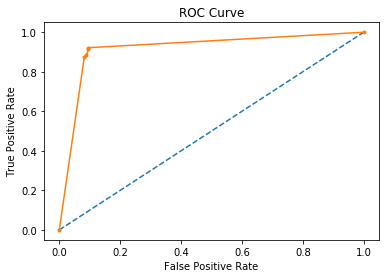

In [12]:
CART = DecisionTreeClassifier()
CART.fit(X_train, y_train)
y_pred = CART.predict(X_test)

model_eval(y_test, y_pred)

print('\n')
print('-------------------------------------------------------------------')
print('-------------------------------------------------------------------')
print('\n')
print('CROSS VALIDATION')
cross_validation(5, CART, features, labels)
print('\n')
print('-------------------------------------------------------------------')
print('-------------------------------------------------------------------')
print('\n')
print('ROC CURVE')
plot_roc_curve(CART, X_test, y_test)

## Random Forest



CONFUSION MATRIX (predicted along top, actual along side): 


,Phishing,Legitimate
Phishing,133,7
Legitimate,13,121




             precision    recall  f1-score   support

   Phishing       0.91      0.95      0.93       140
 Legitimate       0.95      0.90      0.92       134

avg / total       0.93      0.93      0.93       274



-------------------------------------------------------------------
-------------------------------------------------------------------


CROSS VALIDATION
Test data set average precision across 5 folds:
[0.92557617 0.93185387 0.88716356 0.90839438 0.92674918]

Test data set average recall across 5 folds:
[0.92272727 0.93181818 0.88636364 0.90825688 0.9266055 ]

Test data set average fscore across 5 folds:
[0.92259774 0.93181677 0.88630491 0.90824916 0.92659933]


CONFUSION MATRIX (predicted along top, actual along side): 


,Phishing,Legitimate
Phishing,501,47
Legitimate,66,482




             precision    recall  f1-score   support

   Phishing       0.88      0.91      0.90       548
 Legitimate       0.91      0.88      0.90       548

avg / total       0.90      0.90      0.90      1096



-------------------------------------------------------------------
-------------------------------------------------------------------


ROC CURVE
AUC: 0.979


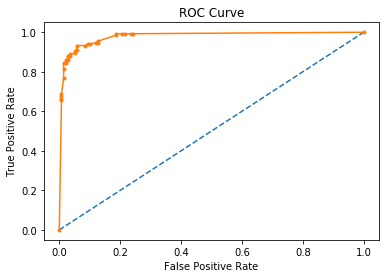

In [18]:
RF = RandomForestClassifier()
RF.fit(X_train, y_train)
y_pred = RF.predict(X_test)

model_eval(y_test, y_pred)

print('\n')
print('-------------------------------------------------------------------')
print('-------------------------------------------------------------------')
print('\n')
print('CROSS VALIDATION')
cross_validation(5, RF, features, labels)
print('\n')
print('-------------------------------------------------------------------')
print('-------------------------------------------------------------------')
print('\n')
print('ROC CURVE')
plot_roc_curve(RF, X_test, y_test)

## K Nearest Neighbor



CONFUSION MATRIX (predicted along top, actual along side): 


,Phishing,Legitimate
Phishing,133,7
Legitimate,16,118




             precision    recall  f1-score   support

   Phishing       0.89      0.95      0.92       140
 Legitimate       0.94      0.88      0.91       134

avg / total       0.92      0.92      0.92       274



-------------------------------------------------------------------
-------------------------------------------------------------------


CROSS VALIDATION
Test data set average precision across 5 folds:
[0.94094553 0.94560185 0.90963257 0.89532726 0.91869987]

Test data set average recall across 5 folds:
[0.94090909 0.94545455 0.90909091 0.89449541 0.91743119]

Test data set average fscore across 5 folds:
[0.94090787 0.94545004 0.90906085 0.89443988 0.9173686 ]


CONFUSION MATRIX (predicted along top, actual along side): 


,Phishing,Legitimate
Phishing,502,46
Legitimate,68,480




             precision    recall  f1-score   support

   Phishing       0.88      0.92      0.90       548
 Legitimate       0.91      0.88      0.89       548

avg / total       0.90      0.90      0.90      1096



-------------------------------------------------------------------
-------------------------------------------------------------------


ROC CURVE
AUC: 0.976


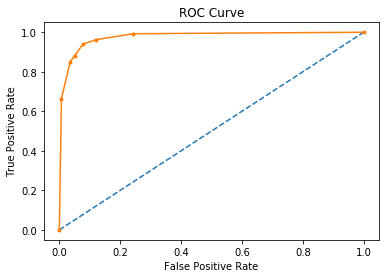

In [26]:
KNN = KNeighborsClassifier(n_neighbors=6)
KNN.fit(X_train, y_train)
y_pred = KNN.predict(X_test)

model_eval(y_test, y_pred)

print('\n')
print('-------------------------------------------------------------------')
print('-------------------------------------------------------------------')
print('\n')
print('CROSS VALIDATION')
cross_validation(5, KNN, features, labels)
print('\n')
print('-------------------------------------------------------------------')
print('-------------------------------------------------------------------')
print('\n')
print('ROC CURVE')
plot_roc_curve(KNN, X_test, y_test)

## Logistic Regression



CONFUSION MATRIX (predicted along top, actual along side): 


,Phishing,Legitimate
Phishing,134,6
Legitimate,13,121




             precision    recall  f1-score   support

   Phishing       0.91      0.96      0.93       140
 Legitimate       0.95      0.90      0.93       134

avg / total       0.93      0.93      0.93       274



-------------------------------------------------------------------
-------------------------------------------------------------------


CROSS VALIDATION
Test data set average precision across 5 folds:
[0.92166667 0.92304193 0.90457889 0.88124737 0.91869987]

Test data set average recall across 5 folds:
[0.91818182 0.92272727 0.90454545 0.88073394 0.91743119]

Test data set average fscore across 5 folds:
[0.91801242 0.9227129  0.90454348 0.88069378 0.9173686 ]


CONFUSION MATRIX (predicted along top, actual along side): 


,Phishing,Legitimate
Phishing,499,49
Legitimate,64,484




             precision    recall  f1-score   support

   Phishing       0.89      0.91      0.90       548
 Legitimate       0.91      0.88      0.90       548

avg / total       0.90      0.90      0.90      1096



-------------------------------------------------------------------
-------------------------------------------------------------------


ROC CURVE
AUC: 0.982


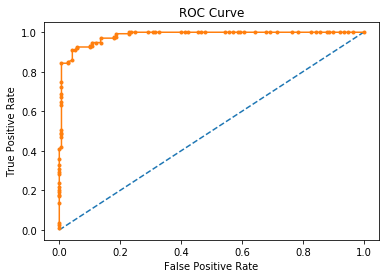

In [27]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

model_eval(y_test, y_pred)

print('\n')
print('-------------------------------------------------------------------')
print('-------------------------------------------------------------------')
print('\n')
print('CROSS VALIDATION')
cross_validation(5, logreg, features, labels)
print('\n')
print('-------------------------------------------------------------------')
print('-------------------------------------------------------------------')
print('\n')
print('ROC CURVE')
plot_roc_curve(logreg, X_test, y_test)